In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from typing import Dict, Tuple
from sklearn.datasets import load_diabetes
from operator import itemgetter
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, r2_score, mean_squared_error, mean_absolute_error, accuracy_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR, LinearSVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import LinearRegression

import warnings

warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline 
sns.set(style="ticks")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html#sklearn.datasets.load_diabetes
diabetes = load_diabetes()

In [4]:
diabetes.feature_names

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

In [5]:
df_diabet = pd.DataFrame(diabetes.data,columns=diabetes.feature_names)
df_diabet['target'] = pd.Series(diabetes.target)
df_diabet.head()

age       sex       bmi        bp  ...        s4        s5        s6  target
0  0.038076  0.050680  0.061696  0.021872  ... -0.002592  0.019908 -0.017646   151.0
1 -0.001882 -0.044642 -0.051474 -0.026328  ... -0.039493 -0.068330 -0.092204    75.0
2  0.085299  0.050680  0.044451 -0.005671  ... -0.002592  0.002864 -0.025930   141.0
3 -0.089063 -0.044642 -0.011595 -0.036656  ...  0.034309  0.022692 -0.009362   206.0
4  0.005383 -0.044642 -0.036385  0.021872  ... -0.002592 -0.031991 -0.046641   135.0

[5 rows x 11 columns]

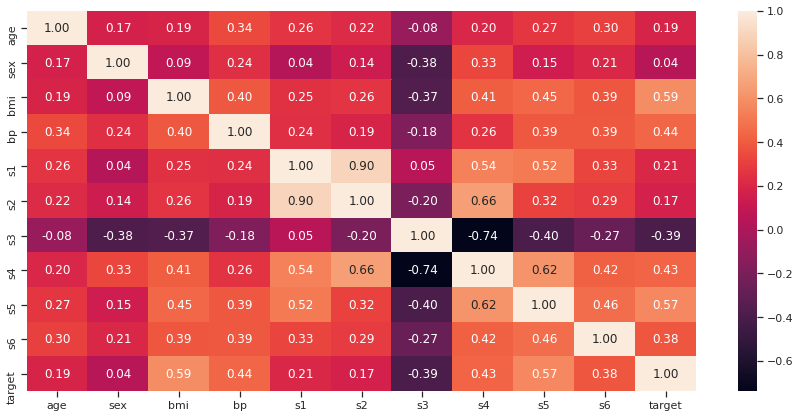

In [6]:
#Построим корреляционную матрицу
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(df_diabet.corr(method='pearson'), ax=ax, annot=True, fmt='.2f')

In [7]:
df_diabet.isnull().sum()

age       0
sex       0
bmi       0
bp        0
s1        0
s2        0
s3        0
s4        0
s5        0
s6        0
target    0
dtype: int64

In [0]:
X = df_diabet.drop("target", axis = 1)
Y = df_diabet["target"]

diabet_X_train, diabet_X_test, diabet_y_train, diabet_y_test = train_test_split(
   X, Y, test_size=0.25, random_state=1)

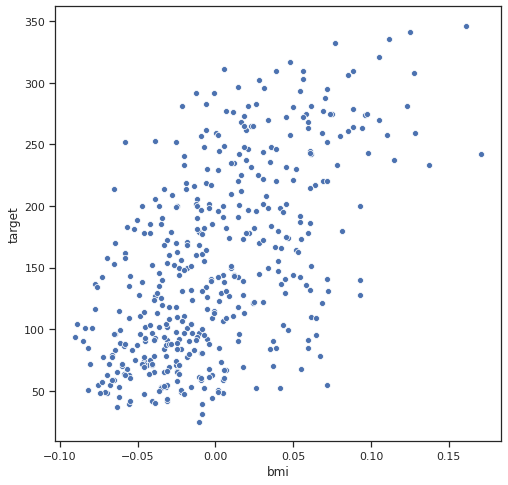

In [9]:
fig, ax = plt.subplots(figsize=(8,8)) 
sns.scatterplot(ax=ax, x='bmi', y='target', data=df_diabet)

In [0]:
# Аналитическое вычисление коэффициентов регрессии
def analytic_regr_coef(x_array : np.ndarray, 
                       y_array : np.ndarray) -> Tuple[float, float]:
    x_mean = np.mean(x_array)
    y_mean = np.mean(y_array)
    var1 = np.sum([(x-x_mean)**2 for x in x_array])
    cov1 = np.sum([(x-x_mean)*(y-x_mean) for x, y in zip(x_array, y_array)])
    b1 = cov1 / var1
    b0 = y_mean - b1*x_mean
    return b0, b1

   

In [0]:
   x_array = df_diabet['bmi'].values
   y_array = df_diabet['target'].values

  

In [12]:
b0, b1 = analytic_regr_coef(x_array, y_array)
b0, b1

(152.1334841628967, 949.4352603839488)

In [0]:
# Вычисление значений y на основе x для регрессии
def y_regr(x_array : np.ndarray, b0: float, b1: float) -> np.ndarray:
    res = [b1*x+b0 for x in x_array]
    return res

In [0]:
y_array_regr = y_regr(x_array, b0, b1)

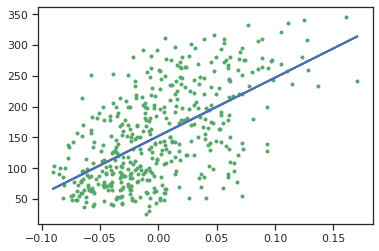

In [15]:
plt.plot(x_array, y_array, 'g.')
plt.plot(x_array, y_array_regr, 'b', linewidth=2.0)
plt.show()

In [0]:
# Простейшая реализация градиентного спуска
def gradient_descent(x_array : np.ndarray,
                     y_array : np.ndarray,
                     b0_0 : float,
                     b1_0 : float,
                     epochs : int,
                     learning_rate : float = 0.001
                    ) -> Tuple[float, float]:
    # Значения для коэффициентов по умолчанию
    b0, b1 = b0_0, b1_0
    k = float(len(x_array))
    for i in range(epochs): 
        # Вычисление новых предсказанных значений
        # используется векторизованное умножение и сложение для вектора и константы
        y_pred = b1 * x_array + b0
        # Расчет градиентов
        # np.multiply - поэлементное умножение векторов
        dL_db1 = (-2/k) * np.sum(np.multiply(x_array, (y_array - y_pred)))
        dL_db0 = (-2/k) * np.sum(y_array - y_pred)
        # Изменение значений коэффициентов:
        b1 = b1 - learning_rate * dL_db1
        b0 = b0 - learning_rate * dL_db0
    # Результирующие значения
    y_pred = b1 * x_array + b0
    return b0, b1, y_pred
    

In [0]:
def show_gradient_descent(epochs, b0_0, b1_0):
    grad_b0, grad_b1, grad_y_pred = gradient_descent(x_array, y_array, b0_0, b1_0, epochs)
    print('b0 = {} - (теоретический), {} - (градиентный спуск)'.format(b0, grad_b0))
    print('b1 = {} - (теоретический), {} - (градиентный спуск)'.format(b1, grad_b1))
    print('MSE = {}'.format(mean_squared_error(y_array_regr, grad_y_pred)))
    plt.plot(x_array, y_array, 'g.')
    plt.plot(x_array, y_array_regr, 'b', linewidth=2.0)
    plt.plot(x_array, grad_y_pred, 'r', linewidth=2.0)
    plt.show()

b0 = 152.1334841628967 - (теоретический), 151.8453261432874 - (градиентный спуск)
b1 = 949.4352603839488 - (теоретический), 900.2231841436541 - (градиентный спуск)
MSE = 5.562284926348945


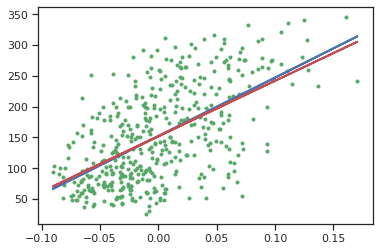

In [18]:
show_gradient_descent(1000, 150, 900)

b0 = 152.1334841628967 - (теоретический), 152.133484162889 - (градиентный спуск)
b1 = 949.4352603839488 - (теоретический), 192.23899338239013 - (градиентный спуск)
MSE = 1297.163318464262


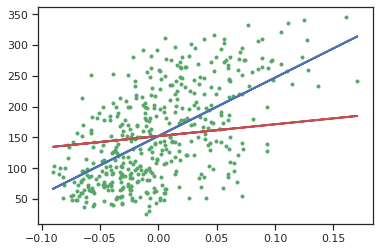

CPU times: user 1.03 s, sys: 4.67 ms, total: 1.04 s
Wall time: 1.04 s


In [19]:
%%time
show_gradient_descent(50000, 0, 0)

b0 = 152.1334841628967 - (теоретический), 152.13348416288912 - (градиентный спуск)
b1 = 949.4352603839488 - (теоретический), 345.55397359749446 - (градиентный спуск)
MSE = 825.051150522472


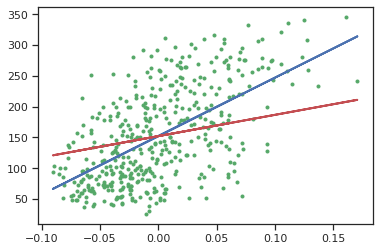

CPU times: user 2.4 s, sys: 642 µs, total: 2.41 s
Wall time: 2.41 s


In [49]:
%%time
show_gradient_descent(100000, 0, 0)

b0 = 152.1334841628967 - (теоретический), 152.1334841628896 - (градиентный спуск)
b1 = 949.4352603839488 - (теоретический), 939.147342045425 - (градиентный спуск)
MSE = 0.23945987271528094


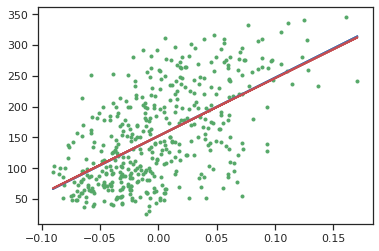

CPU times: user 22.2 s, sys: 416 µs, total: 22.2 s
Wall time: 22.2 s


In [50]:
%%time
show_gradient_descent(1000000, 0, 0)

In [20]:
# Обучим линейную регрессию и сравним коэффициенты с рассчитанными ранее
reg1 = LinearRegression().fit(x_array.reshape(-1, 1), y_array.reshape(-1, 1))
(b1, reg1.coef_), (b0, reg1.intercept_)

((949.4352603839488, array([[949.43526038]])),
 (152.1334841628967, array([152.13348416])))

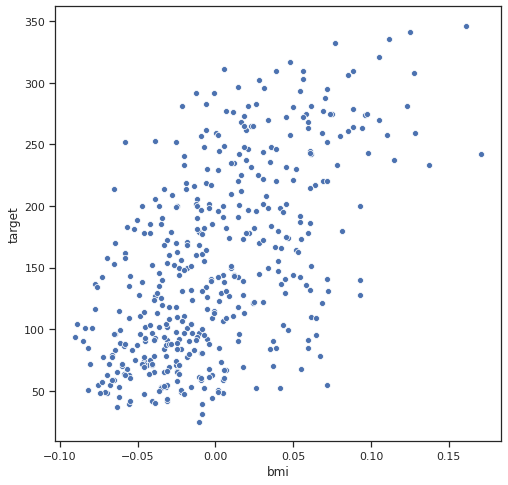

In [21]:
fig, ax = plt.subplots(figsize=(8,8)) 
sns.scatterplot(ax=ax, x='bmi', y='target', data=df_diabet)

In [0]:
def plot_regr(clf):
    title = clf.__repr__
    clf.fit(x_array.reshape(-1, 1), y_array)
    diabet_y_pred = clf.predict(x_array.reshape(-1, 1))
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_title(title)
    ax.plot(x_array, y_array, 'b.')
    ax.plot(x_array, diabet_y_pred, 'ro')
    plt.show()

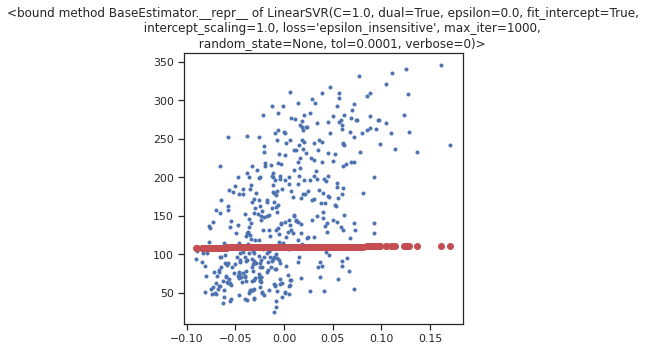

In [44]:
plot_regr(LinearSVR(C=1.0, max_iter=1000))

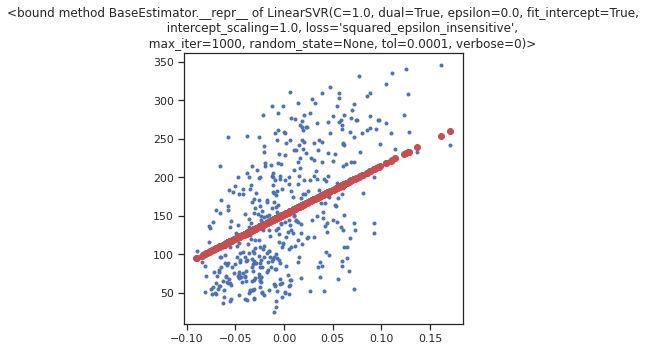

In [71]:
plot_regr(LinearSVR(C=1.0, loss='squared_epsilon_insensitive', max_iter=1000))

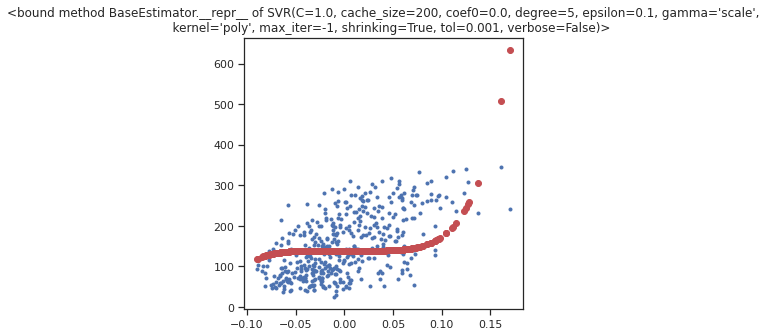

In [76]:
plot_regr(SVR(kernel='poly', degree=5, C=1.0))

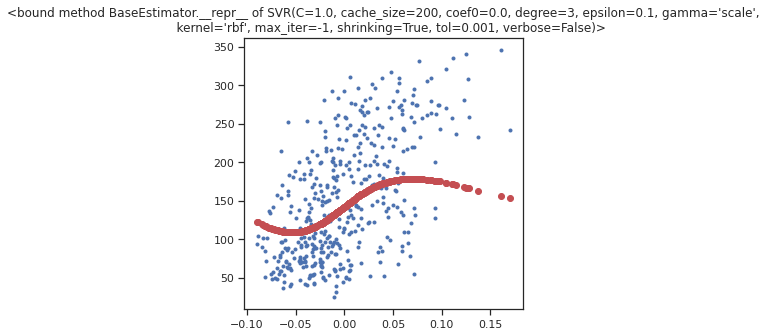

In [52]:
plot_regr(SVR(kernel='rbf',  C=1.0))

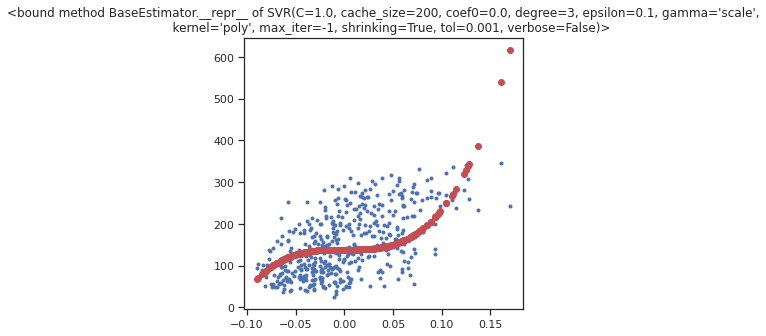

In [75]:
plot_regr(SVR(kernel='poly', degree=3, C=1.0))

In [127]:
# Обучим дерево на всех признаках
diabet_tree_regr = DecisionTreeRegressor(random_state=1)
diabet_tree_regr.fit(diabet_X_train, diabet_y_train)
diabet_tree_regr

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=1, splitter='best')

In [0]:
# Визуализация дерева
def get_png_tree(tree_model_param, feature_names_param):
    dot_data = StringIO()
    export_graphviz(tree_model_param, out_file=dot_data, feature_names=feature_names_param,
                    filled=True, rounded=True, special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph.create_png()


In [0]:
from sklearn.externals.six import StringIO 
from IPython.display import Image
import graphviz 
import pydotplus
import numpy as np
import pandas as pd
from typing import Dict, Tuple
from sklearn.datasets import load_iris, load_wine, load_boston
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline 

In [0]:
list1 = ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

In [131]:
from IPython.display import Image
Image(get_png_tree(diabet_tree_regr, list1), height="500")

In [133]:
# Важность признаков
list(zip(diabet_X_train.columns.values, diabet_tree_regr.feature_importances_))

[('age', 0.03290456477753383),
 ('sex', 0.01997876046652106),
 ('bmi', 0.41029895688483775),
 ('bp', 0.1226911028639813),
 ('s1', 0.03314704947730252),
 ('s2', 0.03414161619524617),
 ('s3', 0.045904930587711994),
 ('s4', 0.03926289403331077),
 ('s5', 0.20620371994288975),
 ('s6', 0.055466404770664765)]

In [134]:
# Важность признаков в сумме дает единицу
sum(diabet_tree_regr.feature_importances_)

0.9999999999999999

In [0]:
from operator import itemgetter

def draw_feature_importances(tree_model, X_dataset, figsize=(15,7)):
    """
    Вывод важности признаков в виде графика
    """
    # Сортировка значений важности признаков по убыванию
    list_to_sort = list(zip(X_dataset.columns.values, tree_model.feature_importances_))
    sorted_list = sorted(list_to_sort, key=itemgetter(1), reverse = True)
    # Названия признаков
    labels = [x for x,_ in sorted_list]
    # Важности признаков
    data = [x for _,x in sorted_list]
    # Вывод графика
    fig, ax = plt.subplots(figsize=figsize)
    ind = np.arange(len(labels))
    plt.bar(ind, data)
    plt.xticks(ind, labels, rotation='vertical')
    # Вывод значений
    for a,b in zip(ind, data):
        plt.text(a-0.05, b+0.01, str(round(b,3)))
    plt.show()
    return labels, data

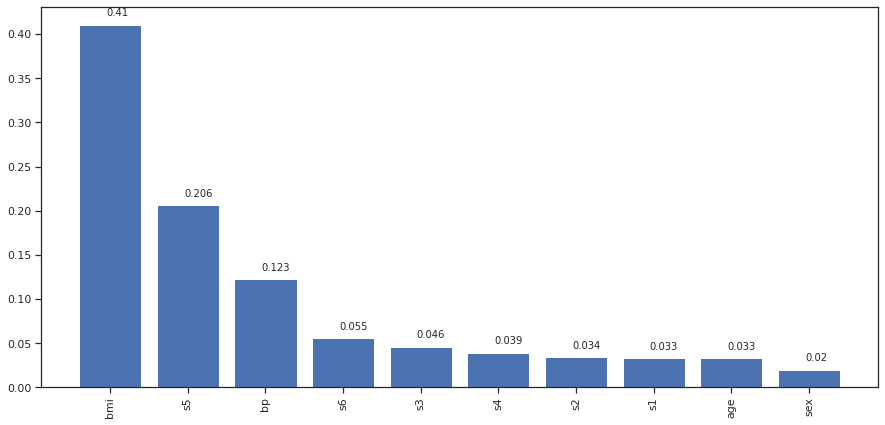

In [136]:
diabet_tree_regr_fl, diabet_tree_regr_fd = draw_feature_importances(diabet_tree_regr, diabet_X_train)

In [137]:
# Список признаков, отсортированный на основе важности, и значения важности
diabet_tree_regr_fl, diabet_tree_regr_fd

(['bmi', 's5', 'bp', 's6', 's3', 's4', 's2', 's1', 'age', 'sex'],
 [0.41029895688483775,
  0.20620371994288975,
  0.1226911028639813,
  0.055466404770664765,
  0.045904930587711994,
  0.03926289403331077,
  0.03414161619524617,
  0.03314704947730252,
  0.03290456477753383,
  0.01997876046652106])

In [138]:
diabet_X_train.head()

age       sex       bmi  ...        s4        s5        s6
168  0.001751  0.050680  0.059541  ...  0.108111  0.068982  0.127328
324  0.030811 -0.044642  0.005650  ...  0.108111  0.066048  0.019633
41  -0.099961 -0.044642 -0.067641  ... -0.039493 -0.049868 -0.009362
180 -0.038207  0.050680  0.004572  ...  0.034309  0.016305 -0.001078
162 -0.052738 -0.044642  0.030440  ... -0.002592 -0.030751 -0.001078

[5 rows x 10 columns]

In [140]:
# Пересортируем признаки на основе важности
X_train_sorted = diabet_X_train[diabet_tree_regr_fl]
X_train_sorted.head()

bmi        s5        bp  ...        s1       age       sex
168  0.059541  0.068982 -0.002228  ...  0.061725  0.001751  0.050680
324  0.005650  0.066048  0.011544  ...  0.078236  0.030811 -0.044642
41  -0.067641 -0.049868 -0.108957  ... -0.074494 -0.099961 -0.044642
180  0.004572  0.016305  0.035644  ... -0.011201 -0.038207  0.050680
162  0.030440 -0.030751 -0.074528  ... -0.023584 -0.052738 -0.044642

[5 rows x 10 columns]

In [0]:
Y_predict_1 = diabet_tree_regr.predict(diabet_X_test)

In [147]:
mean_absolute_error(diabet_y_test, Y_predict_1)

62.846846846846844

In [0]:
# Обучим дерево и предскажем результаты на пяти лучших признаках 
diabet_tree_regr_2= DecisionTreeRegressor(random_state=1).fit(
    X_train_sorted[diabet_tree_regr_fl[0:5]], diabet_y_train)
Y_predict_2 = diabet_tree_regr_2.predict(diabet_X_test[diabet_tree_regr_fl[0:5]])

In [150]:
# Ошибка стала меньше
mean_absolute_error(diabet_y_test, Y_predict_2)

60.252252252252255

In [151]:
# Исследуем, как изменяется ошибка при добавлении признаков в порядке значимости
diabet_X_range = list(range(1, len(diabet_X_train.columns)+1))
diabet_X_range

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [0]:
mae_list = []
for i in diabet_X_range:
    # Обучим дерево и предскажем результаты на заданном количестве признаков 
    diabet_tree_regr_3 = DecisionTreeRegressor(random_state=1).fit(
        diabet_X_train[diabet_tree_regr_fl[0:i]], diabet_y_train)
    Y_predict_3 = diabet_tree_regr_3.predict(diabet_X_test[diabet_tree_regr_fl[0:i]])
    temp_mae = mean_absolute_error(diabet_y_test, Y_predict_3)
    mae_list.append(temp_mae)

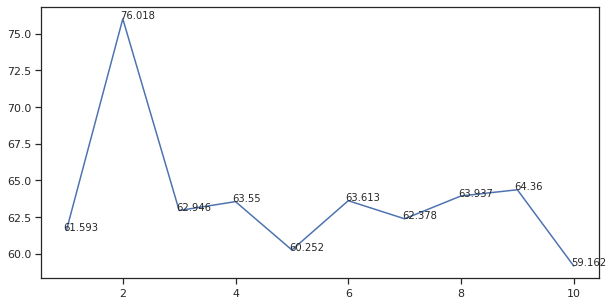

In [153]:
plt.subplots(figsize=(10,5))
plt.plot(diabet_X_range, mae_list)
for a,b in zip(diabet_X_range, mae_list):
    plt.text(a-0.05, b+0.01, str(round(b,3)))
plt.show()

In [156]:
pred = reg1.predict(x_array.reshape(-1,1))
print("r2_score: ", r2_score(y_array, pred))
print("mean_squared_error", mean_squared_error(y_array, pred))

r2_score:  0.3439237602253803
mean_squared_error 3890.4565854612724


In [160]:
svr = SVR(kernel='rbf')
svr.fit(diabet_X_train, diabet_y_train)
print("r2_score: ", r2_score(diabet_y_test,svr.predict(diabet_X_test)))
print("mean_squared_error", mean_squared_error(diabet_y_test,svr.predict(diabet_X_test)))

r2_score:  0.16255422958881272
mean_squared_error 4372.438334171242


In [162]:
print("r2_score: ", r2_score(diabet_y_test, diabet_tree_regr.predict(diabet_X_test)))
print("mean_squared_error", mean_squared_error(diabet_y_test, diabet_tree_regr.predict(diabet_X_test)))

r2_score:  -0.18555685261935384
mean_squared_error 6189.981981981982
